### Project initialization
Setup the environment with correct path and imports

In [ ]:
# Environment variables:
LOCAL_PATH = r"/home/harry/FEEG3003/vocal_ddsp/"
SAMPLE_RATE = 16000
FRAME_RATE = 250

In [11]:
# pyright: reportMissingImports=false, reportUnusedVariable=warning, reportUntypedBaseClass=error

import sys
from pathlib import Path
import os

# Check wether local or collab
IS_COLAB = 'google.colab' in sys.modules
print('IS_COLAB:', IS_COLAB)

# Enable seamless running on local machine or google colab, changing path as necessary
if IS_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    PROJECT_PATH = Path('/content/drive/My Drive/vocal_ddsp')

    # Import DDSP to collab, assumed to be in local already
    %tensorflow_version 2.x
    %pip install -qU ddsp==1.9.0
    %pip install apache-beam
    %pip install python-snappy
    
else:
    PROJECT_PATH = Path(LOCAL_PATH)
  
import ddsp
from typing import List, Tuple
from ddsp.training.data_preparation.prepare_tfrecord_lib import prepare_tfrecord

if not PROJECT_PATH.exists():
    raise Exception(f'Project path {PROJECT_PATH} does not exist')

# Check if separated data exists
SEPERATED_PATH = PROJECT_PATH.joinpath('separated')

if not SEPERATED_PATH.exists():
    raise Exception(f"Separated data path not found at '{SEPERATED_PATH}'") 

print(f"PROJECT_PATH: {PROJECT_PATH}")

IS_COLAB: True
Mounted at /content/drive
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.37.0 requires httplib2<0.20.0,>=0.8, but you have httplib2 0.20.4 which is incompatible.
  Using cached httplib2-0.19.1-py3-none-any.whl (95 kB)
  Attempting uninstall: httplib2
    Found existing installation: httplib2 0.20.4
    Uninstalling httplib2-0.20.4:
      Successfully uninstalled httplib2-0.20.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ddsp 1.9.0 requires httplib2>=0.20.2, but you have httplib2 0.19.1 which is incompatible.


PROJECT_PATH: /content/drive/My Drive/vocal_ddsp


### Data preparation
A TFRecordDataSet is created from a specified path in the separated folder, this is then exported to the dataset folder.

In [12]:
TRAINING_DATASET_PATH = f"{str(PROJECT_PATH)}/training_data"
import shutil

def prepare_dataset(folder: str):
    """Prepares a TFRecordDataSet from a selection of files in the separated folder"""

    if isinstance(folder, str):
        # If starting with a '/' remove it
        if folder.startswith('/'):
            folder = folder[1:]
        # If ending with '/' remove it
        if folder[-1] == '/':
            folder = folder[:-1]
        
        actual_path = f"{str(SEPERATED_PATH)}/{folder}"
    else:
        raise Exception(f"Folder must be a string, not {type(folder)}")
    
    output_name = folder.replace('/', '_').replace(' ', '_')

    print("actual_path", actual_path)
    if not Path(actual_path).exists():
      raise Exception(f"The actual_path {actual_path} does not exist")

    # If ends with _, remove it
    if output_name.endswith('_'):
        output_name = output_name[:-1]
    
    output_folder = f"{TRAINING_DATASET_PATH}/{output_name}/"
    print(f"Output folder: {output_folder}")

    if not Path(output_folder).exists():
        os.makedirs(Path(output_folder))
        assert Path(output_folder).exists()
      
    # Get all wav files in path
    input_paths = list(Path(actual_path).glob('**/*.wav'))
    print(f"Found {len(input_paths)} wav files in {actual_path}")

    # Convert inpited paths to strings
    input_paths = [str(path) for path in input_paths]

    print("input_paths:", input_paths)

    output_path = f"{output_folder}train.tfrecord"

    prepare_tfrecord(input_paths, output_path, num_shards=10, frame_rate=250)
    

    

In [14]:
prepare_dataset("TaylorSwiftSelected/")

actual_path /content/drive/My Drive/vocal_ddsp/separated/TaylorSwiftSelected
Output folder: /content/drive/My Drive/vocal_ddsp/training_data/TaylorSwiftSelected/
Found 25 wav files in /content/drive/My Drive/vocal_ddsp/separated/TaylorSwiftSelected
input_paths: ['/content/drive/My Drive/vocal_ddsp/separated/TaylorSwiftSelected/6.wav', '/content/drive/My Drive/vocal_ddsp/separated/TaylorSwiftSelected/7.wav', '/content/drive/My Drive/vocal_ddsp/separated/TaylorSwiftSelected/8.wav', '/content/drive/My Drive/vocal_ddsp/separated/TaylorSwiftSelected/9.wav', '/content/drive/My Drive/vocal_ddsp/separated/TaylorSwiftSelected/12.wav', '/content/drive/My Drive/vocal_ddsp/separated/TaylorSwiftSelected/11.wav', '/content/drive/My Drive/vocal_ddsp/separated/TaylorSwiftSelected/13.wav', '/content/drive/My Drive/vocal_ddsp/separated/TaylorSwiftSelected/15.wav', '/content/drive/My Drive/vocal_ddsp/separated/TaylorSwiftSelected/1.wav', '/content/drive/My Drive/vocal_ddsp/separated/TaylorSwiftSelected/2

/usr/local/lib/python3.7/dist-packages/crepe/core.py:209: RuntimeWarning: invalid value encountered in true_divide
  frames /= np.std(frames, axis=1)[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])
/usr/local/lib/python3.7/dist-packages/crepe/core.py:209: RuntimeWarning: invalid value encountered in true_divide
  frames /= np.std(frames, axis=1)[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])
/usr/local/lib/python3.7/dist-packages/crepe/core.py:209: RuntimeWarning: invalid value encountered in true_divide
  frames /= np.std(frames, axis=1)[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])
/usr/local/lib/python3.7/dist-pack

### Check the dataset
Import utils and plot and listen to a part of the trained dataset

In [15]:
from ddsp.colab import colab_utils
from ddsp.colab.colab_utils import play, specplot
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

def get_frame(relative_path, frame_rate=250):
  """Gets a frame from a training dataset"""
  dataset_pattern = f"{TRAINING_DATASET_PATH}/{str(relative_path)}/*"

  if not Path(dataset_pattern[:-2]).exists():
    raise Exception(f"The dataset path {dataset_pattern[:-2]} doesn't exist")
  
  data_provider = ddsp.training.data.TFRecordProvider(dataset_pattern, frame_rate=frame_rate)

  dataset = data_provider.get_dataset(shuffle=False)

  try:
    for i, frame in enumerate(iter(dataset)):
      # Get a 4 second frame someway thorugh the song
      if i == 40:
        return frame
  except StopIteration:
    raise Exception(
        'TFRecord contains no examples. Please try re-running the pipeline with '
        'different audio file(s).')
  except OutOfRangeError:
    raise Exception(
        'TFRecord contains no examples. Please try re-running the pipeline with '
        'different audio file(s).')    

  


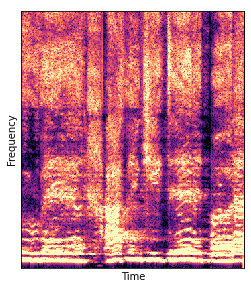

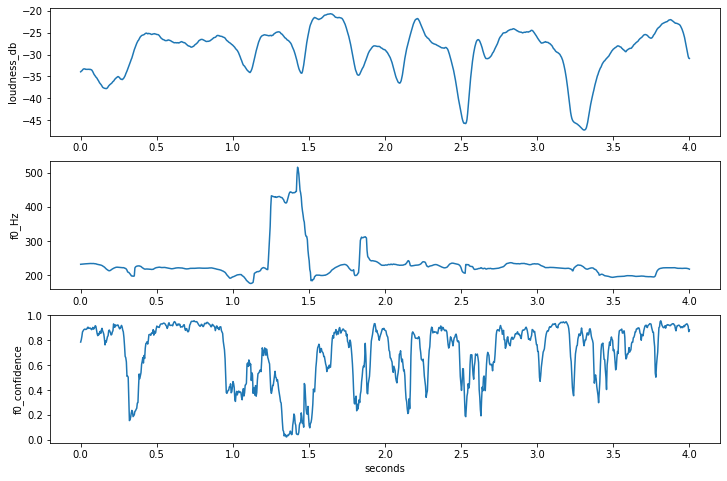

In [18]:
frame = get_frame("TaylorSwiftSelected")

colab_utils.specplot(frame['audio'])
colab_utils.play(frame['audio'])

f, ax = plt.subplots(3, 1, figsize=(12, 8))
x = np.linspace(0, 4.0, frame['loudness_db'].shape[0])
ax[0].set_ylabel('loudness_db')
ax[0].plot(x, frame['loudness_db'])
ax[1].set_ylabel('f0_Hz')
ax[1].plot(x, frame['f0_hz'])
ax[2].set_ylabel('f0_confidence')
ax[2].set_xlabel('seconds')
_ = ax[2].plot(x, frame['f0_confidence'])